In [1]:
from nd2tif.transform import to_8bits
from czifile import imread

In [2]:
from nd2_combine import tools
from segment import seg
from droplet_growth import multiwell
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import math
import pandas as pd
import re
from skimage.morphology import convex_hull_image
from skimage.transform import rotate
from scipy.ndimage import gaussian_filter1d as gf
from scipy.interpolate import interp1d
import seaborn as sns
import json
import re
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

In [3]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(sm, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return labels


In [4]:
def read_czi(path, channels:list = ['BF', 'TRITC', 'FITC'], plot=1) -> dict:
    stack = imread(path)[0,1:,:,:,0]
    stack8 = to_8bits(stack)
    print(path)
    print(stack.shape)
    rgb = np.stack([*stack8, np.zeros_like(stack8[0])], axis=-1)
    if plot:
        plt.imshow(rgb)
        plt.show()
    return {'path': path, 'stack': stack, 'rgb': rgb}

  
def process_2_colors(stack:dict, min_size=50, bins=20, staining=['TRITC', 'FITC'], plot=True, **kwargs):
    path, stack, rgb = stack.values()
    tritc, fitc = stack
    print('fitc')
    labels = segment_bf(fitc, thr=.4, plot=plot)
    props = multiwell.regionprops(labels)
    filtered_props = list(filter(lambda p: p.major_axis_length > min_size, props))
    print(f'{len(filtered_props)} regions after filtering using min size {min_size}')
    
    datas = []
    for ind, prop in enumerate(filtered_props):
        mask = labels == prop.label
        good_mask = convex_hull_image(mask).astype(int)
        if plot:
            plt.imshow(good_mask)
            plt.title('Convex area')
            plt.show()
        
        I_tritc = multiwell.regionprops(good_mask, intensity_image=tritc)[0].mean_intensity
        I_fitc = multiwell.regionprops(good_mask, intensity_image=fitc)[0].mean_intensity
        
        convex_prop = multiwell.regionprops(good_mask)[0]
        
        data = {'path': path, 
                'size_px': prop.major_axis_length,
                'area': prop.area,
                'perimeter': prop.perimeter,
                'circularity': prop.area / (prop.perimeter ** 2),
                'convex_area': convex_prop.area,
                'convex_eccentricity': convex_prop.eccentricity,
                'convex_perimeter': convex_prop.perimeter,
                'convex_circularity': convex_prop.area / (convex_prop.perimeter ** 2),
                'convex_eccentricity': convex_prop.eccentricity,
                'tritc': I_tritc,
                'fitc': I_fitc,
                'index': ind, 
                **kwargs
        }
        datas.append(data)
    df = pd.DataFrame(datas)
    return df

In [6]:
fluo_path = r'/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/*/*.czi'
flist = glob(fluo_path)
flist

['/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w1.czi',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w2.czi',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w6.czi',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w30.czi',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w17.czi',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w28.czi',
 '/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her

In [8]:
ree = re.compile(r'11062020/(.*)/.*10X_(\d*)-(w\d*)')
list(map(ree.findall, flist))

[[('12µl chip', '1000', 'w1')],
 [('12µl chip', '1000', 'w2')],
 [('12µl chip', '1000', 'w6')],
 [('12µl chip', '1000', 'w30')],
 [('12µl chip', '1000', 'w17')],
 [('12µl chip', '1000', 'w28')],
 [('12µl chip', '1000', 'w7')],
 [('12µl chip', '1000', 'w16')],
 [('12µl chip', '1000', 'w15')],
 [('12µl chip', '1000', 'w12')],
 [('12µl chip', '1000', 'w20')],
 [('12µl chip', '1000', 'w5')],
 [('12µl chip', '1000', 'w14')],
 [('12µl chip', '1000', 'w4')],
 [('12µl chip', '1000', 'w18')],
 [('12µl chip', '1000', 'w29')],
 [('12µl chip', '1000', 'w27')],
 [('12µl chip', '1000', 'w10')],
 [('12µl chip', '1000', 'w11')],
 [('12µl chip', '1000', 'w21')],
 [('12µl chip', '1000', 'w23')],
 [('12µl chip', '1000', 'w13')],
 [('12µl chip', '1000', 'w22')],
 [('12µl chip', '1000', 'w9')],
 [('12µl chip', '1000', 'w24')],
 [('12µl chip', '1000', 'w26')],
 [('12µl chip', '1000', 'w3')],
 [('12µl chip', '1000', 'w25')],
 [('12µl chip', '1000', 'w8')],
 [('12µl chip', '1000', 'w31')],
 [('12µl chip', '10

/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w1.czi
/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w1.czi
(2, 2048, 2048)


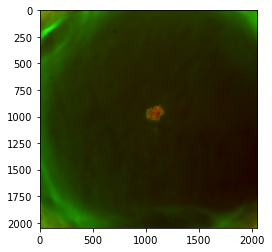

fitc
1 regions


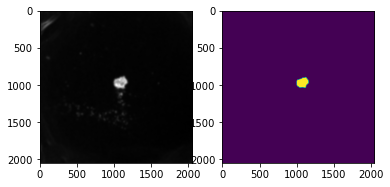

1 regions after filtering using min size 50


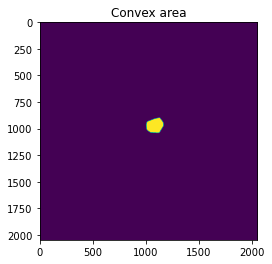

/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w2.czi
/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w2.czi
(2, 2048, 2048)


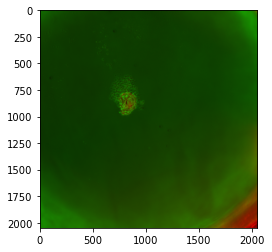

fitc
4 regions


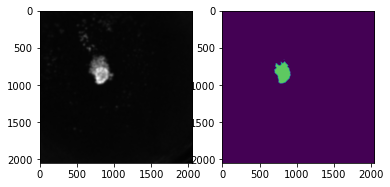

1 regions after filtering using min size 50


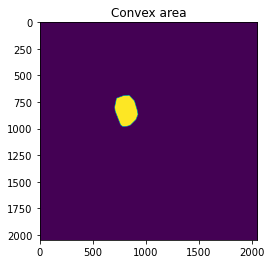

/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w6.czi
/home/aaristov/Multicell/Sebastien/Neurospheres_melina_sebastien/Large chips test/11062020/12µl chip/GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w6.czi
(2, 2048, 2048)


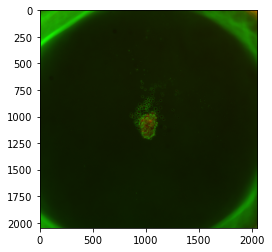

fitc
3 regions


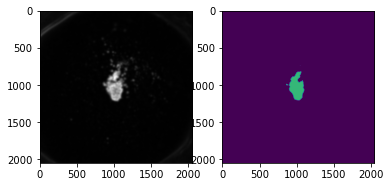

1 regions after filtering using min size 50


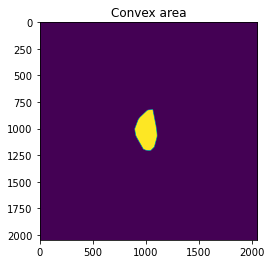

In [9]:
results = pd.DataFrame()
for f in flist[:3]:
    print(f)
    condition, cell_number, well = ree.findall(f)[0]
    rgb = read_czi(f, plot=True)
    result = process_2_colors(rgb, plot=True, min_size=50, condition=condition, cell_number=cell_number, well=well)
    results = pd.concat((results, result))


In [23]:
results

path     size_px   area  \
0  Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  168.025850  16839   
0  Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  298.951470  61825   
0  Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  380.092897  41612   

     perimeter  circularity  convex_area  convex_eccentricity  \
0   517.688384     0.062832        17753             0.584708   
0  1126.466125     0.048722        68545             0.316843   
0  1075.317893     0.035987        55400             0.829061   

   convex_perimeter  convex_circularity       tritc          fitc  index  \
0        513.203102            0.067405  783.429730  27378.862051      0   
0        997.719913            0.068859  757.742811  21899.860851      0   
0        968.891486            0.059015  873.259386  24790.378899      0   

   condition cell_number well  
0  12µl chip        1000   w1  
0  12µl chip        1000  w10  
0  12µl chip        1000  w11

In [24]:
results = pd.DataFrame()
for f in flist[:]:
    condition, cell_number, well = re.compile(r'MT200611\\(.*)\\.*10X_(\d*)-(w\d*)').findall(f)[0]
    rgb = read_czi(f, plot=False)
    result = process_2_colors(rgb, plot=False, min_size=150, condition=condition, cell_number=cell_number, well=well)
    results = pd.concat((results, result))


Z:/Sebastien/Neurospheres_melina_sebastien/Large chips test\MT200611\12µl chip\GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w1.czi
(2, 2048, 2048)
fitc
1 regions
1 regions after filtering using min size 150
Z:/Sebastien/Neurospheres_melina_sebastien/Large chips test\MT200611\12µl chip\GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w10.czi
(2, 2048, 2048)
fitc
1 regions
1 regions after filtering using min size 150
Z:/Sebastien/Neurospheres_melina_sebastien/Large chips test\MT200611\12µl chip\GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w11.czi
(2, 2048, 2048)
fitc
1 regions
1 regions after filtering using min size 150
Z:/Sebastien/Neurospheres_melina_sebastien/Large chips test\MT200611\12µl chip\GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w12.czi
(2, 2048, 2048)
fitc
5 regions
1 regions after filtering using min size 150
Z:/Sebastien/Neurospheres_melina_sebastien/Large chips test\MT200611\12µl chip\GFAP-GFP_her-dRFP_P4_12µl_10X_1000-w13.czi
(2, 2048, 2048)
fitc
1 regions
1 regions after filtering using min size 150
Z:/Sebastie

In [25]:
results

path     size_px   area  \
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  168.025850  16839   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  298.951470  61825   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  380.092897  41612   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  211.618311  30177   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  299.917052  43669   
..                                                ...         ...    ...   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  413.281990  61710   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  240.851193  36660   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  612.975805  24674   
1   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  231.424779  28943   
0   Z:/Sebastien/Neurospheres_melina_sebastien/Lar...  624.031604  61207   

      perimeter  circularity  convex_area  convex_eccentricity  \
0    517.688384     0.062832        17753             0.584708   
0   1126.466125     0.048722        68545             0.316843   
0   1075.317893     0.035987        55400             0.829061   
0    719.913780     0.058226        32528             0.530541   
0    906.400108     0.053154        47440             0.764892   
..          ...          ...          ...                  ...   
0   1357.959595     0.033464        80072             0.835721   
0    760.624458     0.063365        38082             0.542308   
0   1666.616449     0.008883        68569             0.965151   
1    745.630555     0.052059        32400             0.622663   
0   2079.547473     0.014153       134645             0.781424   

    convex_perimeter  convex_circularity        tritc          fitc  index  \
0         513.203102            0.067405   783.429730  27378.862051      0   
0         997.719913            0.068859   757.742811  21899.860851      0   
0         968.891486            0.059015   873.259386  24790.378899      0   
0         696.031529            0.067143  1349.329286  24878.571139      0   
0         851.394011            0.065446  1140.624642  22917.936594      0   
..               ...                 ...          ...           ...    ...   
0        1228.354473            0.053068  1034.332701  15821.025315      0   
0         751.310750            0.067465  1062.975159  16769.520009      0   
0        1495.401154            0.030663   868.706660  14645.681532      0   
1         718.381818            0.062782  1018.350586  17309.862531      1   
0        1622.344371            0.051157   908.559516  14107.064629      0   

        condition cell_number well  
0       12µl chip        1000   w1  
0       12µl chip        1000  w10  
0       12µl chip        1000  w11  
0       12µl chip        1000  w12  
0       12µl chip        1000  w13  
..            ...         ...  ...  
0   96-wells_50µl         700   w6  
0   96-wells_50µl         700   w7  
0   96-wells_50µl         700   w8  
1   96-wells_50µl         700   w8  
0   96-wells_50µl         700   w9  

[65 rows x 15 columns]

In [32]:
results['tritc/fitc'] = results.tritc / results.fitc
results['size_um'] = results.size_px * .65
results['circ'] = results.circularity * 4 * np.pi
results['conv_circ'] = results.convex_circularity * 4 * np.pi

data = results.query('size_px < 600')
# data = results.copy()

In [40]:
data.to_csv(r'Z:\Sebastien\Neurospheres_melina_sebastien\Large chips test\MT200611/results.csv')

In [41]:
def plot(data, x='condition', y='fitc', hue='cell_number', size=3):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(y.upper())

    sns.swarmplot(data=data, x=x, y=y, hue=hue, dodge=1, size=size)
    sns.boxplot(data=data, x=x, y=y, hue=hue, dodge=1, boxprops=dict(alpha=.3))
#     plt.legend(loc=(1,0))
    plt.show()

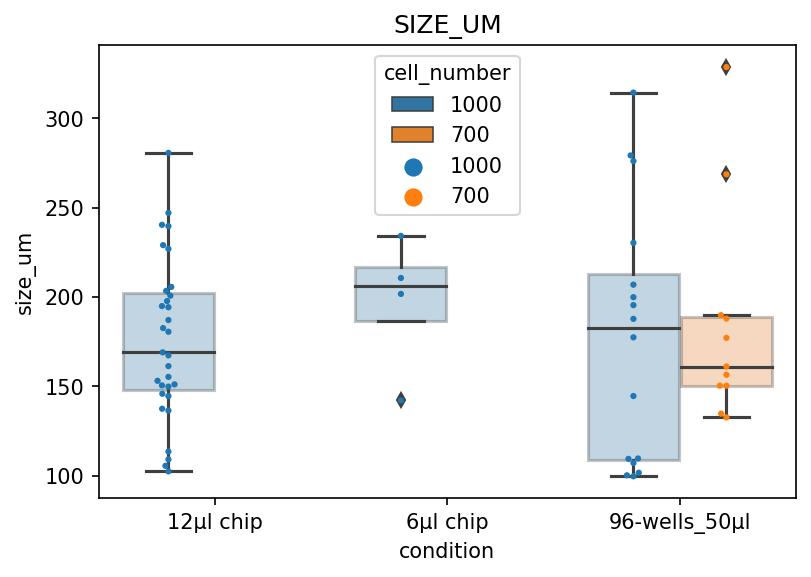

In [42]:

plot(data, y='size_um')

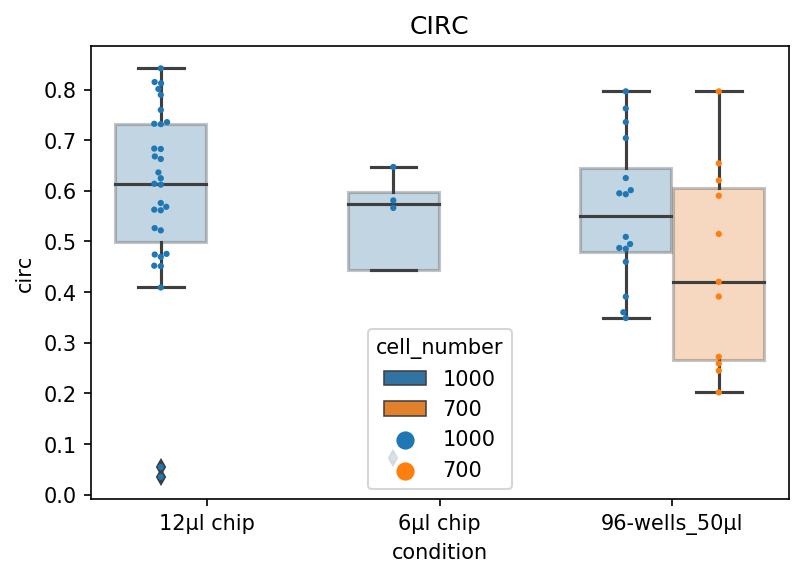

In [43]:
plot(data, y='circ')

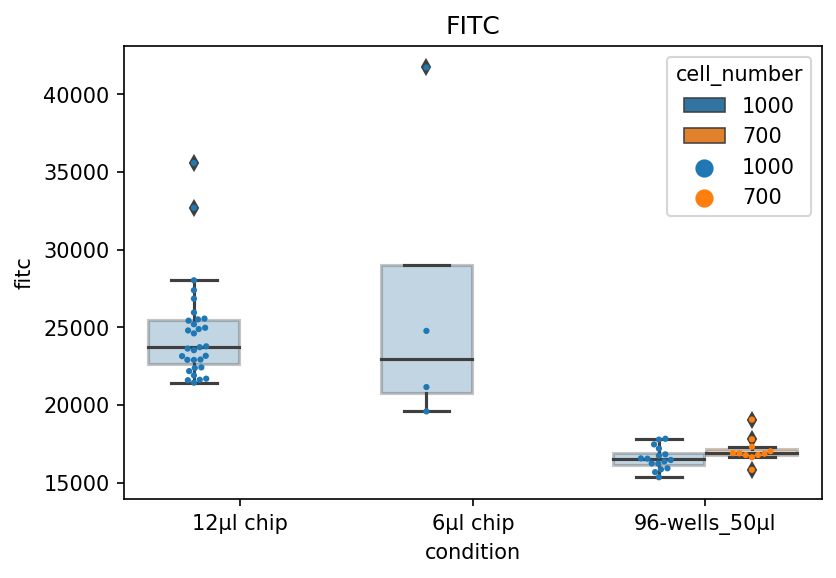

In [44]:
plot(data, y='fitc', size=3)

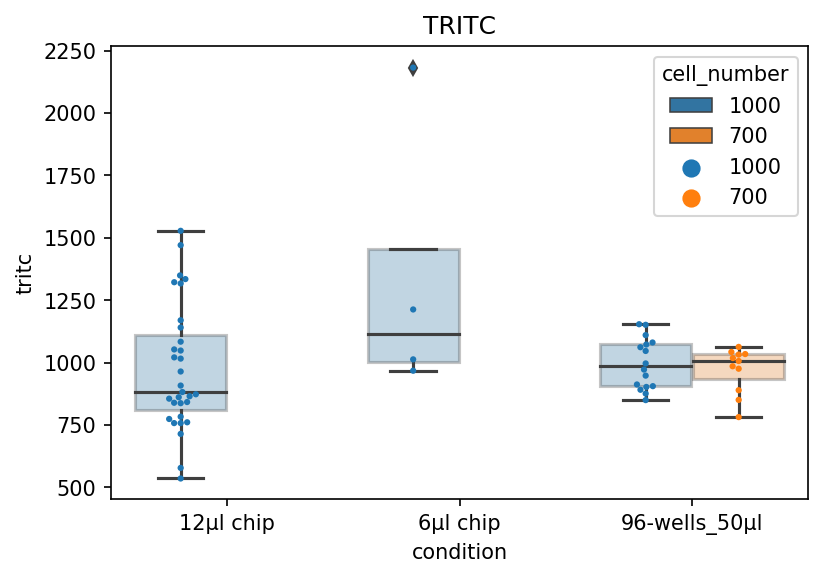

In [45]:
plot(data, y='tritc')

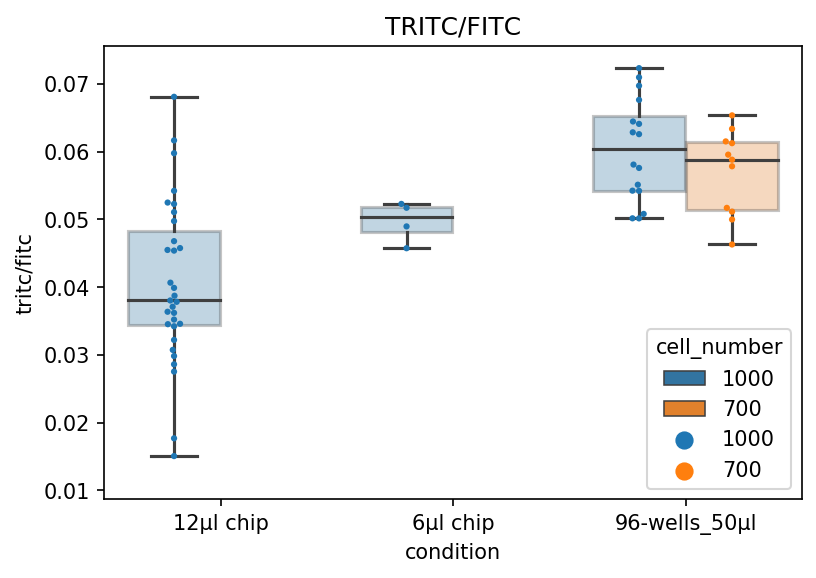

In [46]:
plot(data, y='tritc/fitc')